<a href="https://colab.research.google.com/github/HenriqueScian1/Mapeamento-de-Esqueleto/blob/main/Corpo_pontos_chave_de_uma_pessoa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Corpo - Pontos chave do corpo


## **Etapa 1 - Importando as bibliotecas**

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import zipfile

cv2.__version__

'3.4.3'

## **Etapa 2 - Conectar com o Drive**




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
pose_path = "/content/drive/My Drive/pose.zip"
zip_object = zipfile.ZipFile(file=pose_path, mode="r")
zip_object.extractall("./")

In [ ]:
imagens_path = "/content/drive/My Drive/imagens.zip"
zip_object = zipfile.ZipFile(file=imagens_path, mode="r")
zip_object.extractall("./")
zip_object.close()

## **Etapa 3 - Carregando os modelos e estruturas da rede neural pré-treinados**

In [ ]:
arquivo_proto = "/content/pose/body/mpi/pose_deploy_linevec_faster_4_stages.prototxt"
arquivo_pesos = "/content/pose/body/mpi/pose_iter_160000.caffemodel"

numero_pontos = 15
pares_pontos = [[0, 1], [1, 2], [2, 3], [3, 4], [1, 5], [5, 6], [6, 7],[1,14],
               [14, 8], [8, 9], [9, 10], [14, 11], [11, 12], [12, 13]]

In [ ]:
pares_pontos

[[0, 1],
 [1, 2],
 [2, 3],
 [3, 4],
 [1, 5],
 [5, 6],
 [6, 7],
 [1, 14],
 [14, 8],
 [8, 9],
 [9, 10],
 [14, 11],
 [11, 12],
 [12, 13]]

In [ ]:
cor_ponto, cor_linha = (255, 128, 0), (7, 62, 248)

## **Etapa 4 - Carregando uma imagem do Drive.**

In [ ]:
imagem = cv2.imread("/content/imagens/body/single/single_3.jpg")

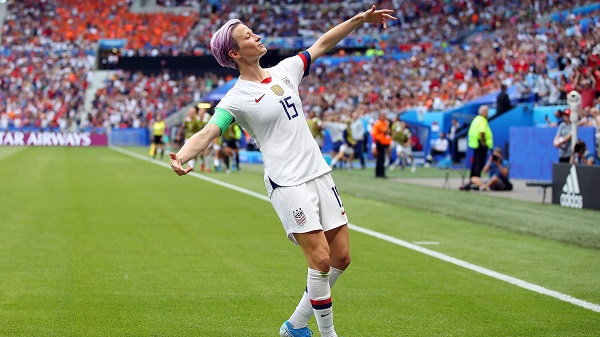

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(imagem)

In [ ]:
imagem_copia = np.copy(imagem)

In [ ]:
imagem_largura = imagem.shape[1]
imagem_altura = imagem.shape[0]

In [ ]:
imagem_largura, imagem_altura

(600, 337)

## **Etapa 5 - Ler o modelo carregado na Etapa 3**



In [ ]:
modelo = cv2.dnn.readNetFromCaffe(arquivo_proto, arquivo_pesos)

## **Etapa 6 - Definir as dimensões da imagem de entrada.**



In [ ]:
altura_entrada = 368
largura_entrada = int((altura_entrada / imagem_altura) * imagem_largura)

In [ ]:
largura_entrada

655

## **Etapa 7 - Converter a imagem do formato openCV para o formato blob Caffe**


In [ ]:
blob_entrada = cv2.dnn.blobFromImage(imagem, 1.0 / 255,
                                    (largura_entrada, altura_entrada),
                                    (0, 0, 0), swapRB = False, crop = False)

## **Etapa 8 - Saída**

In [ ]:
modelo.setInput(blob_entrada)
saida = modelo.forward()

In [ ]:
saida.shape

(1, 44, 46, 82)

In [ ]:
altura = saida.shape[2]
largura = saida.shape[3]

In [ ]:
altura, largura

(46, 82)

## **Etapa 9 - Plotando as saídas na imagem**


In [ ]:
pontos = []
limite = 0.1
for i in range(numero_pontos):
  mapa_confianca = saida[0, i, :, :]
  _, confianca, _, ponto = cv2.minMaxLoc(mapa_confianca)
  #print(confianca)
  #print(ponto)

  x = (imagem_largura * ponto[0]) / largura
  y = (imagem_altura * ponto[1] / altura)

  if confianca > limite:
    cv2.circle(imagem_copia, (int(x), int(y)), 8, cor_ponto, thickness = -1,
               lineType=cv2.FILLED)
    cv2.putText(imagem_copia, "{}".format(i), (int(x), int(y)),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3,
                lineType=cv2.LINE_AA)
    pontos.append((int(x), int(y)))
  else:
    pontos.append(None)

In [ ]:
len(pontos)

15

In [ ]:
pontos

[(226, 21),
 (248, 65),
 (226, 95),
 (204, 131),
 (175, 153),
 (278, 65),
 (314, 43),
 (358, 14),
 (285, 183),
 (314, 256),
 (321, 329),
 (314, 168),
 (336, 256),
 (292, 315),
 (278, 124)]

## Etapa 10: Criando uma máscara para desenho do esqueleto

In [ ]:
tamanho = cv2.resize(imagem, (imagem_largura, imagem_altura))
mapa_suave = cv2.GaussianBlur(tamanho, (3,3), 0, 0)
mascara_mapa = np.uint8(mapa_suave > limite)

## **Etapa 11 - Desenhar o esqueleto: quando temos os pontos chave, apenas juntamos os pares**

In [ ]:
for par in pares_pontos:
  #print(par)
  parteA = par[0]
  parteB = par[1]

  if pontos[parteA] and pontos[parteB]:
    cv2.line(imagem, pontos[parteA], pontos[parteB], cor_linha, 3)
    cv2.circle(imagem, pontos[parteA], 8, cor_ponto, thickness = -1,
              lineType = cv2.LINE_AA)

    cv2.line(mascara_mapa, pontos[parteA], pontos[parteB], cor_linha, 3)
    cv2.circle(mascara_mapa, pontos[parteA], 8, cor_ponto, thickness = -1,
              lineType = cv2.LINE_AA)

## **Etapa 12 - Exibindo as saídas**

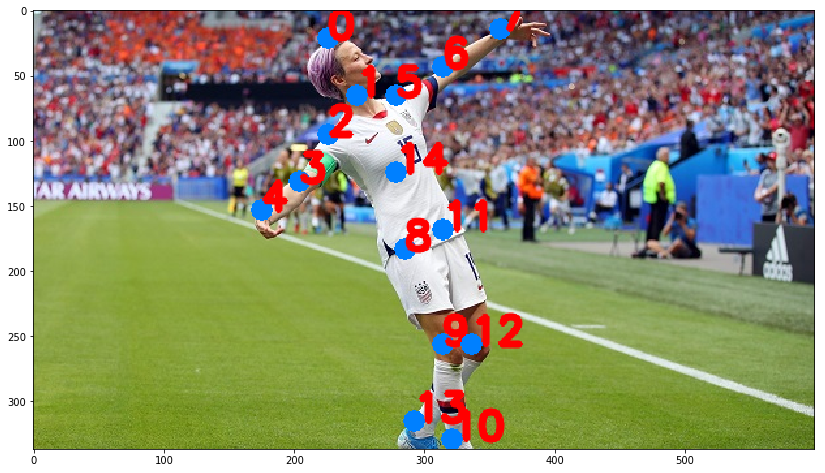

In [ ]:
plt.figure(figsize = [14,10])
plt.imshow(cv2.cvtColor(imagem_copia, cv2.COLOR_BGR2RGB))

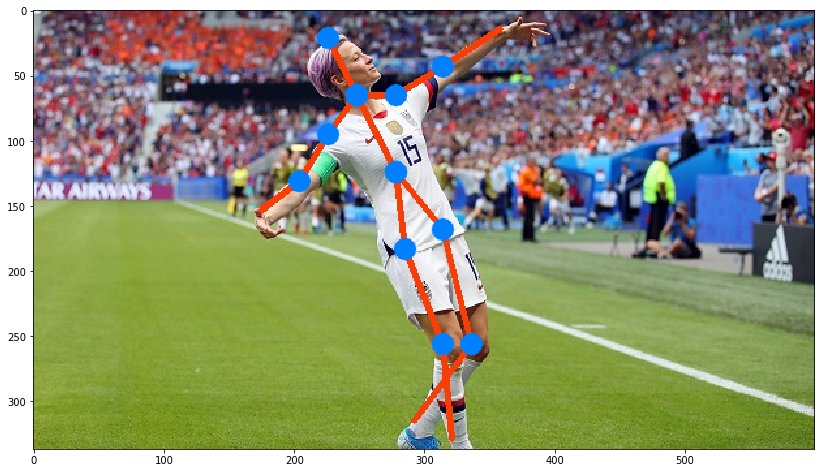

In [ ]:
plt.figure(figsize = [14,10])
plt.imshow(cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB))

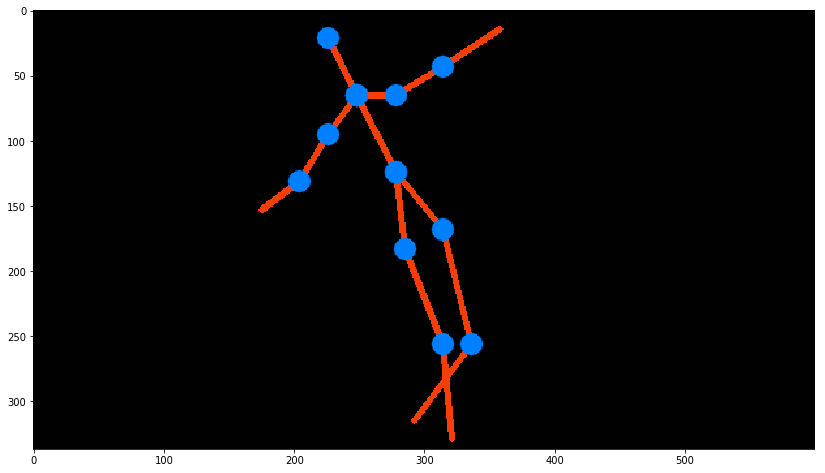

In [ ]:
plt.figure(figsize = [14,10])
plt.imshow(cv2.cvtColor(mascara_mapa, cv2.COLOR_BGR2RGB))